In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE

from textblob import TextBlob

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
from google.colab import files
uploaded = files.upload()

Saving upload_DJIA_table.csv to upload_DJIA_table.csv


In [34]:

# Load and merge data
# we have stock market data and the news headlines data
# Ensure the Date column is in a datetime format so that both dataframes can be merged correctly
# then we Merge the news data with the stock data using the shared Date column

df_news = pd.read_csv("Combined_News_DJIA.csv")
df_stock = pd.read_csv("upload_DJIA_table.csv")
df_news['Date'] = pd.to_datetime(df_news['Date'])
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df = pd.merge(df_news, df_stock, on="Date", how="inner")

In [35]:
# we define clean_text function
# we clean and preprocess the text data


stop = set(stopwords.words("english"))   #Load a list of common English stopwords
lemmatizer = WordNetLemmatizer()   #Load a lemmatizer, which reduces words to their root form

def clean_text(text):
    text = re.sub(r"b[\"']", " ", str(text).lower())
    text = re.sub(r"\[.*?\]\(.*?\)", "", text)
    text = re.sub(r"[^\w\s]", " ", text)  ## remove punctuation
    text = re.sub(r"\s+", " ", text)  # remove extra whitespace
    tokens = word_tokenize(text)    # tokenize into words
    output = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop]
    return " ".join(output)

# Clean each headline column individually
# This goes through all 25 headline columns (Top1 to Top25) and cleans each headline using the clean_text function
headline_cols = [f'Top{i}' for i in range(1, 26)]
for col in headline_cols:
    df[col] = df[col].astype(str).apply(clean_text)


In [36]:
# we perform VADER sentiment analysis on all 25 cleaned news headlines (Top1 to Top25) and then computing the average sentiment score for each day

sid = SentimentIntensityAnalyzer()  #we load the VADER model for sentiment scoring


#Apply VADER to each of the 25 columns (headlines)
for col in headline_cols:
    scores = df[col].astype(str).apply(sid.polarity_scores)
    for v in ['compound', 'pos', 'neg', 'neu']:  #Extracts the 4 VADER scores for each headline
        df[f"{col}_{v}"] = scores.apply(lambda x: x[v])


#Calculate the average sentiment scores across all 25 headlines for each day
for v in ['compound', 'pos', 'neg', 'neu']:
    df[f"mean_{v}"] = df[[f"{col}_{v}" for col in headline_cols]].mean(axis=1)


/tmp/ipython-input-36-2128142689.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{v}"] = scores.apply(lambda x: x[v])
/tmp/ipython-input-36-2128142689.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{v}"] = scores.apply(lambda x: x[v])
/tmp/ipython-input-36-2128142689.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

In [37]:
# we select the features and target

features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'mean_compound', 'mean_pos', 'mean_neg', 'mean_neu'
]
target = 'Adj Close'

#Drop rows with missing values
df = df.dropna(subset=features + [target]).reset_index(drop=True)


In [38]:
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top24_neg,Top24_neu,Top25_compound,Top25_pos,Top25_neg,Top25_neu,mean_compound,mean_pos,mean_neg,mean_neu
0,2008-08-08,0,georgia down two russian warplane country move...,breaking musharraf impeached,russia today column troop roll south ossetia f...,russian tank moving towards capital south osse...,afghan child raped impunity u n official say s...,russian tank entered south ossetia whilst geor...,breaking georgia invades south ossetia russia ...,enemy combatent trial nothing sham salim haman...,...,0.746,0.254,0.4019,0.474,0.000,0.526,-0.356156,0.06772,0.26456,0.66772
1,2008-08-11,1,wont america nato help u wont help u help iraq,bush put foot georgian conflict,jewish georgian minister thanks israeli traini...,georgian army flees disarray russian advance g...,olympic opening ceremony firework faked,mossad fraudulent new zealand passport iraq,russia angered israeli military sale georgia,american citizen living ossetia blame u georgi...,...,0.443,0.227,0.0000,0.000,0.000,1.000,-0.216880,0.07952,0.27404,0.64640
2,2008-08-12,0,remember adorable year old sang opening ceremo...,russia end georgia operation,sexual harassment would child,al qa eda losing support iraq brutal crackdown...,ceasefire georgia putin outmaneuvers west,microsoft intel tried kill xo laptop,stratfor russo georgian war balance power,trying get sense whole georgia russia war vote...,...,0.000,1.000,0.0000,0.000,0.000,1.000,-0.252652,0.08596,0.23308,0.68092
3,2008-08-13,0,u refuse israel weapon attack iran report,president ordered attack tskhinvali capital so...,israel clear troop killed reuters cameraman,britain policy tough drug pointless say former...,body year old found trunk latest ransom paid k...,china moved million quake survivor prefab home,bush announces operation get russia grill yeah...,russian force sink georgian ship,...,0.237,0.763,-0.3400,0.000,0.255,0.745,-0.117928,0.09384,0.18520,0.72088
4,2008-08-14,1,expert admit legalise drug,war south osetia picture made russian soldier,swedish wrestler ara abrahamian throw away med...,russia exaggerated death toll south ossetia or...,missile killed inside pakistan may launched cia,rushdie condemns random house refusal publish ...,poland u agree missle defense deal interesting...,russian conquer tblisi bet seriously bet,...,0.619,0.381,0.7096,0.457,0.000,0.543,-0.164324,0.12552,0.23036,0.64416


In [8]:
# Train Test Split
# we split the dataset based on time and scale the data

train = df[df['Date'] < '2015-01-01']
test  = df[df['Date'] >= '2015-01-01']

# Scaling with MinMaxScaler
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = X_scaler.fit_transform(train[features])  #fit_transform on training data, learns min-max values and scales to [0, 1]
y_train = y_scaler.fit_transform(train[[target]])
X_test  = X_scaler.transform(test[features])       #transform on test data,it uses the same scaling learned from training
y_test  = y_scaler.transform(test[[target]])


In [ ]:
#Sequence Creation
# we creates sequences for LSTM input, because LSTMs need sequential data, so this transforms raw data into time windows.

SEQ_LEN = 10   # Convert the input data into sequences of fixed length (SEQ_LEN = 10)
#The function create_sequences() slides a window of size 10 over your data
def create_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])  # sequence of 10 days
        ys.append(y[i+seq_len])   # label is the price on the next day
    return np.array(Xs), np.array(ys)


# X_train_seq and X_test_seq become 3D arrays, the Shape is (number of sequences, sequence length, number of features)
# y_train_seq and y_test_seq become 2D arrays of the target values (next-day prices)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, SEQ_LEN)

In [ ]:
# we define and compile an LSTM model

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)



# LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, X_train_seq.shape[2])), # The first LSTM layer with 128 units
    Dropout(0.1), # Prevents overfitting
    LSTM(64, return_sequences=True), #Second LSTM layer with 64 units
    Dropout(0.1),
    LSTM(32), #Third LSTM layer
    Dropout(0.1),
    Dense(1) # Output layer, predicts a single value (next day's stock price).
])

#Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse') #mse (mean squared error) for regression.

In [ ]:
# trains the LSTM model

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=200, # un through the entire training data up to 200 times
    batch_size=8, # processes 8 sequences at a time
    validation_split=0.1, # 10% of your training data is used as validation data to check how the model performs on unseen data
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1 #You’ll see progress printed during training
)

Epoch 1/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0175 - val_loss: 7.2446e-04
Epoch 2/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 3/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 5/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0021 - val_loss: 5.6215e-04
Epoch 6/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0017 - val_loss: 5.5118e-04
Epoch 7/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 8/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 9/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 10/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0018 - val_loss: 7.3420e-04
Epoch 11/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0012 - val_loss: 4.4610e-04
Epoch 12/2

In [ ]:
#early_stop = EarlyStopping(monitor = 'val_loss', mode = 'auto', patience=10, restore_best_weights=True)
#history = model.fit(X_train_seq, y_train_seq, batch_size=16,epochs=100,verbose=1,validation_data=(X_test_seq, y_test_seq),callbacks = [early_stop])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
📊 MSE: 35202.5655
📉 RMSE: 187.6235
📈 MAE: 147.9095
🎯 R² Score: 0.9126
MAPE: 0.86%


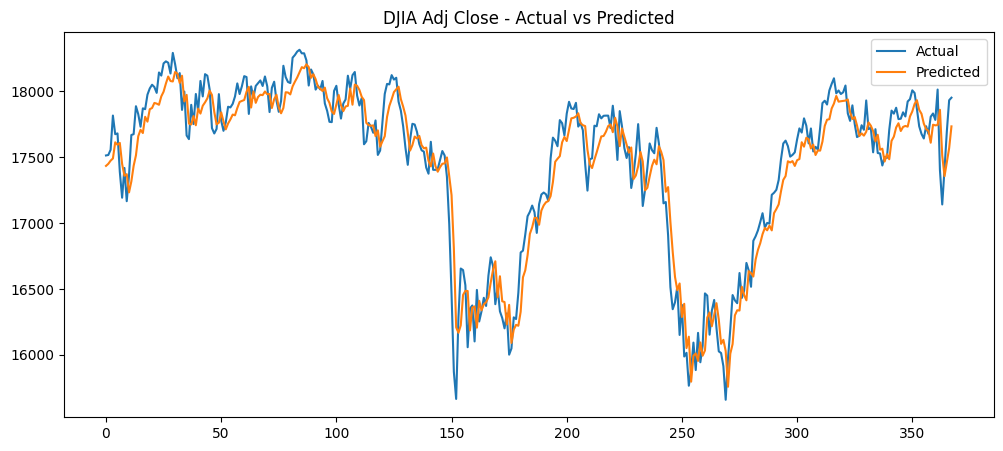

In [ ]:
#evaluating the performance of trained LSTM


# Prediction and Inverse Scaling
y_pred = model.predict(X_test_seq)
y_test_inv = y_scaler.inverse_transform(y_test_seq)
y_pred_inv = y_scaler.inverse_transform(y_pred)

#  Error Metrics
# These measure how close predictions are to real values
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) *100

#Print Results
print(f"📊 MSE: {mse:.4f}")
print(f"📉 RMSE: {rmse:.4f}")
print(f"📈 MAE: {mae:.4f}")
print(f"🎯 R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title('DJIA Adj Close - Actual vs Predicted')
plt.show()


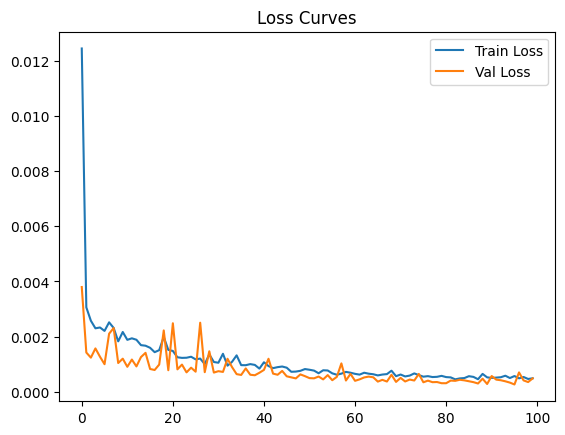

In [ ]:
#training and validation loss curves over epochs

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [ ]:
#we evaluate how well the LSTM model fits the training and test data using the R² score

train_preds = model.predict(X_train_seq)
val_preds = model.predict(X_test_seq)

#calculate the R² score for both predictions
print("Train R²:", r2_score(y_train_seq, train_preds))
print("Val R²:", r2_score(y_test_seq, val_preds))

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Train R²: 0.9951390512510572
Val R²: 0.9163633247857362
